# **Classification of Anomalies in the Gastrointestinal Tract using Deep Learning**
## Using **Hyper-Kvasir** dataset

Changes from initial model:

1.   Image input size increased from 224 to 400






In [ ]:
# Necessary imports

import cv2
import glob
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


## Loading the dataset

#### Download the dataset and extract the class folders

In [ ]:
!wget https://datasets.simula.no/hyper-kvasir/hyper-kvasir-labeled-images.zip

--2021-03-18 05:02:40--  https://datasets.simula.no/hyper-kvasir/hyper-kvasir-labeled-images.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3928814344 (3.7G) [application/zip]
Saving to: ‘hyper-kvasir-labeled-images.zip’

hyper-kvasir-labele 100%[===================>]   3.66G  15.4MB/s    in 3m 23s  

2021-03-18 05:06:02 (18.5 MB/s) - ‘hyper-kvasir-labeled-images.zip’ saved [3928814344/3928814344]



In [ ]:
!unzip "/content/hyper-kvasir-labeled-images.zip"

Streaming output truncated to the last 5000 lines.
  inflating: labeled-images/lower-gi-tract/pathological-findings/ulcerative-colitis-grade-1/86719d8f-d9d0-4262-b714-fc4f64fc253b.jpg  
  inflating: labeled-images/lower-gi-tract/pathological-findings/ulcerative-colitis-grade-1/146604b0-4121-4da1-b4ac-2fd797a0fea2.jpg  
  inflating: labeled-images/lower-gi-tract/pathological-findings/ulcerative-colitis-grade-1/814842e4-0369-46a3-895a-917f7904f31c.jpg  
  inflating: labeled-images/lower-gi-tract/pathological-findings/ulcerative-colitis-grade-1/8630387c-644d-4abf-99f7-40b39ac6b75a.jpg  
  inflating: labeled-images/lower-gi-tract/pathological-findings/ulcerative-colitis-grade-1/57134772-ba95-40ab-9595-07472c6c952a.jpg  
  inflating: labeled-images/lower-gi-tract/pathological-findings/ulcerative-colitis-grade-1/83663117-525e-4f59-81b3-9a7f1809b8e4.jpg  
  inflating: labeled-images/lower-gi-tract/pathological-findings/ulcerative-colitis-grade-1/84603031-571c-4064-a1c9-78df7b9a66f6.jpg  
  in

Since the images are in a folder structure that is 4 subdirectories deep, we use pathlib to get the category subfolders

In [ ]:
from pathlib import Path

p = Path('labeled-images')
category_dirs = [x for x in p.rglob('*') if x.is_dir() and len(x.parts)>=4]
categories = [x.name for x in category_dirs]

In [ ]:
print("Number of categories:", len(categories))

Number of categories: 23


In [ ]:
categories

['impacted-stool',
 'bbps-0-1',
 'bbps-2-3',
 'cecum',
 'retroflex-rectum',
 'ileum',
 'dyed-lifted-polyps',
 'dyed-resection-margins',
 'ulcerative-colitis-grade-2-3',
 'ulcerative-colitis-grade-0-1',
 'ulcerative-colitis-grade-3',
 'ulcerative-colitis-grade-2',
 'polyps',
 'ulcerative-colitis-grade-1',
 'ulcerative-colitis-grade-1-2',
 'hemorrhoids',
 'retroflex-stomach',
 'z-line',
 'pylorus',
 'esophagitis-a',
 'barretts',
 'esophagitis-b-d',
 'barretts-short-segment']

We move all the individual categories in several subdirectories into one directory

In [ ]:
import shutil

for cat_dir in category_dirs:
  shutil.copytree(cat_dir,"/content/hyper-kvasir/"+cat_dir.name)


In [ ]:
datadir= Path("/content/hyper-kvasir")

In [ ]:
# Check if all images have been copied properly
assert len(list(datadir.rglob("*.jpg"))) == len(list(p.rglob("*.jpg")))

In [ ]:
test_img = cv2.imread('/content/hyper-kvasir/barretts-short-segment/03b9c09d-9018-4104-a249-2ec9c471dbf0.jpg')

In [ ]:
test_img.shape

(1015, 1225, 3)

In [ ]:
# Size of the images to feed to the model
img_size = 400

#### Creating tf.data.Dataset objects

Since the dataset is too large to fit in memory, a tf.data.Dataset object is created that will load the images from disk during training



In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  datadir,
  validation_split=0.2,
  subset="training",
  label_mode = 'categorical',
  seed=123,
  image_size=(img_size, img_size),
  batch_size=16)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  datadir,
  validation_split=0.2,
  subset="validation",
  label_mode = 'categorical',
  seed=123,
  image_size=(img_size, img_size),
  batch_size=16)

Found 10662 files belonging to 23 classes.
Using 8530 files for training.
Found 10662 files belonging to 23 classes.
Using 2132 files for validation.


Out of the 10662 images in the dataset, we use 8530 for training and 2132 for validation

## Exploratory data analysis

#### Example images from the dataset

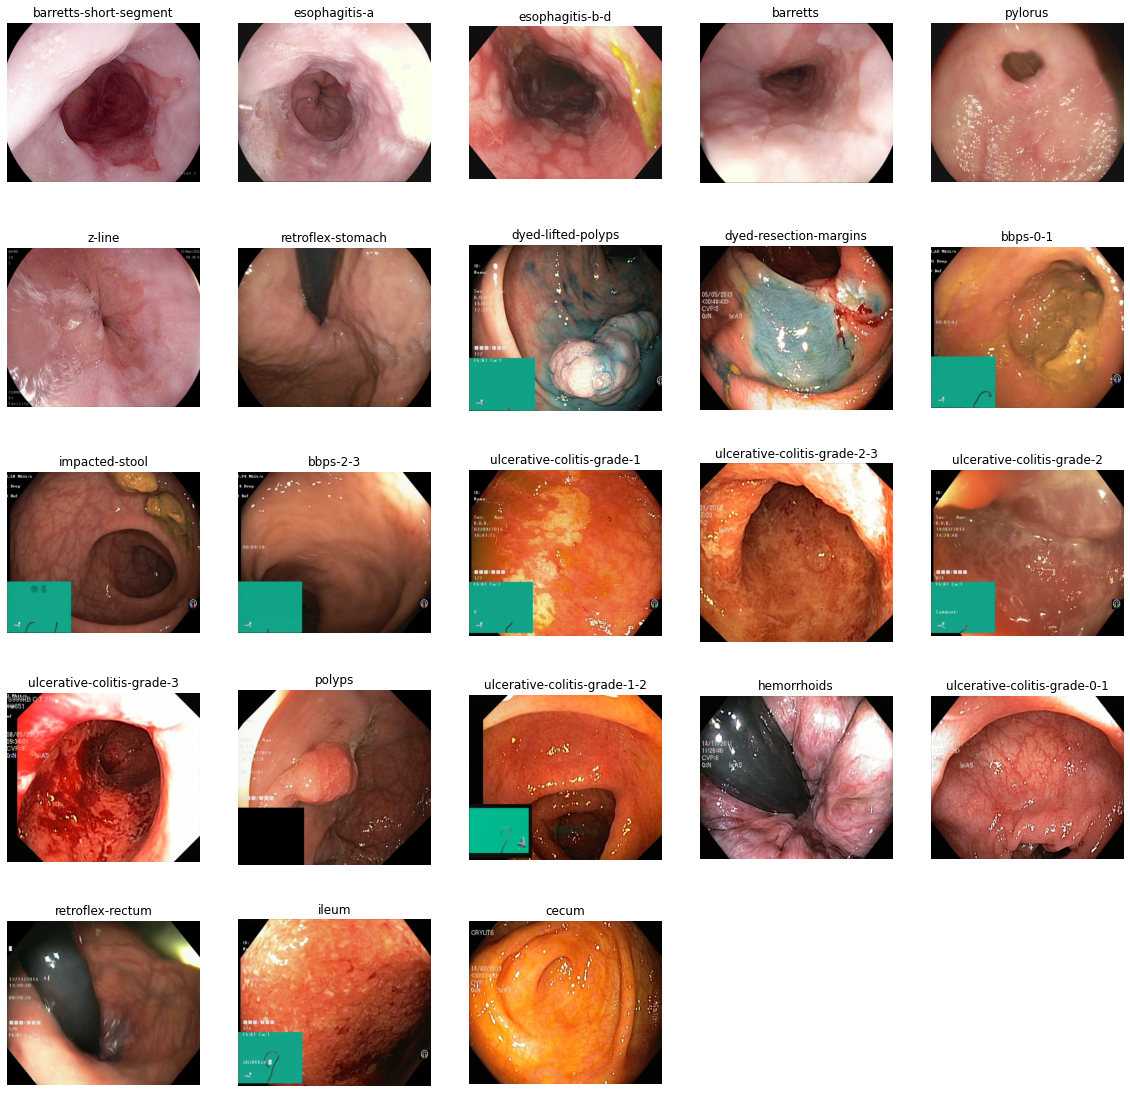

In [ ]:
# Show one example for each category

plt.figure(figsize=(20, 20))
plot_num = 1
for cat_dir in category_dirs:
  img_path = random.choice(os.listdir(cat_dir))
  img = cv2.imread(os.path.join(cat_dir,img_path))
  ax = plt.subplot(5, 5, plot_num)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  plt.title(cat_dir.name)
  plt.axis("off")
  plot_num+=1



#### Number of instances in each category

In [ ]:
category_counts = {}
for cat_dir in [x for x in datadir.rglob('*') if x.is_dir()]:
  category_counts[cat_dir.name] = len(list(cat_dir.glob("*.jpg")))

In [ ]:
category_counts = pd.DataFrame.from_dict(category_counts, orient = "index", columns = ["count"])

In [ ]:
category_counts.sort_values("count")

,count
hemorrhoids,6
ileum,9
ulcerative-colitis-grade-1-2,11
ulcerative-colitis-grade-2-3,28
ulcerative-colitis-grade-0-1,35
barretts,41
barretts-short-segment,53
impacted-stool,131
ulcerative-colitis-grade-3,133
ulcerative-colitis-grade-1,201


This dataset is **heavily imbalanced** with regards to certain classes. This may cause the model to overfit and result in poor f1-score

## Creating the model

#### Loading a pretrained CNN model

In [ ]:
model = applications.DenseNet201(include_top = False, weights = "imagenet", input_shape = (img_size,img_size, 3))

74842112/74836368 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 406, 406, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 200, 200, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 200, 200, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

All the layers of the model are made trainable

In [ ]:
for layer in model.layers:
    layer.trainable=True

#### Creating a data augmentation pipeline

In [ ]:
# Custom data augmentation layer to randomly change brightness of the image. However, using random brightness worsens model performance

class RandomBrightness(tf.keras.layers.Layer):
    def __init__(self, brightness_delta, **kwargs):
        super(RandomBrightness, self).__init__(**kwargs)
        self.brightness_delta = brightness_delta

    def call(self, images, training=None):
        if not training:
            return images
        
        brightness = np.random.uniform(
            -self.brightness_delta, self.brightness_delta)
        
        images = tf.image.adjust_brightness(images, brightness)
        return images

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    # RandomBrightness(0.3),
    layers.experimental.preprocessing.RandomContrast(0.3),
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_size, 
                                                              img_size,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

#### Compiling the final model

In [ ]:
metrics = ["accuracy",
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           tf.keras.metrics.AUC(),
           tf.keras.metrics.TruePositives(),
           tf.keras.metrics.TrueNegatives(),
           tf.keras.metrics.FalsePositives(),
           tf.keras.metrics.FalseNegatives()
           ]

In [ ]:
inputs = tf.keras.Input(shape=(img_size,img_size,3))
augmented = data_augmentation(inputs)
model_input = tf.keras.applications.densenet.preprocess_input(augmented)
output = model(model_input)
x = tf.keras.layers.GlobalAveragePooling2D()(output)
x = tf.keras.layers.Dense(128,activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
predictions = tf.keras.layers.Dense(len(categories), activation="softmax")(x)

model_final = tf.keras.Model(inputs=inputs, outputs=predictions)

In [ ]:
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.001, momentum=0.9),metrics=metrics)

In [ ]:
model_final.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 400, 400, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 400, 400, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 400, 400, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 400, 400, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 400, 400, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, 12, 12, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0     

## Training

In [ ]:
# Creating callbacks to be used during training

anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [ ]:
!nvidia-smi

Thu Mar 18 05:14:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    35W / 250W |    477MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
history=model_final.fit(train_ds.prefetch(tf.data.AUTOTUNE),
          epochs=30,
          verbose=1,
          validation_data=val_ds.prefetch(tf.data.AUTOTUNE),
          callbacks = [anne,checkpoint,early_stopping])

Epoch 1/30
534/534 [==============================] - 269s 502ms/step - loss: 0.7412 - accuracy: 0.7709 - precision: 0.8661 - recall: 0.6723 - auc: 0.9833 - true_positives: 5735.0000 - true_negatives: 186773.0000 - false_positives: 887.0000 - false_negatives: 2795.0000 - val_loss: 0.4555 - val_accuracy: 0.8621 - val_precision: 0.9040 - val_recall: 0.8218 - val_auc: 0.9905 - val_true_positives: 1752.0000 - val_true_negatives: 46718.0000 - val_false_positives: 186.0000 - val_false_negatives: 380.0000

Epoch 00001: val_loss improved from inf to 0.45548, saving model to model.h5
Epoch 2/30
534/534 [==============================] - 259s 483ms/step - loss: 0.5307 - accuracy: 0.8295 - precision: 0.8955 - recall: 0.7727 - auc: 0.9899 - true_positives: 6591.0000 - true_negatives: 186891.0000 - false_positives: 769.0000 - false_negatives: 1939.0000 - val_loss: 0.3640 - val_accuracy: 0.8837 - val_precision: 0.9215 - val_recall: 0.8537 - val_auc: 0.9935 - val_true_positives: 1820.0000 - val_true_

After training for 9 epochs, the best validation accuracy is **90.81%**. After the 10th epoch, the model started to overfit. 

In [ ]:
model_final.save("model.h5")

## Load saved model to continue training

If a saved model exists, it can be loaded and training can start from where it was left off

In [ ]:
save_dir = ""

In [ ]:
saved_model = tf.keras.models.load_model(save_dir)

In [ ]:
# Creating callbacks to be used during training

anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

In [ ]:
history =  saved_model.fit(train_ds.prefetch(tf.data.AUTOTUNE),
              epochs=10,
              verbose=1,
              validation_data=val_ds.prefetch(tf.data.AUTOTUNE),
              callbacks = [anne,checkpoint])

## Visualizing training history

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'true_positives', 'true_negatives', 'false_positives', 'false_negatives', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_true_positives', 'val_true_negatives', 'val_false_positives', 'val_false_negatives', 'lr'])

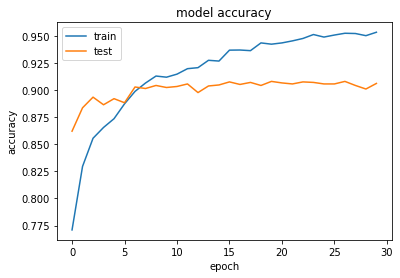

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

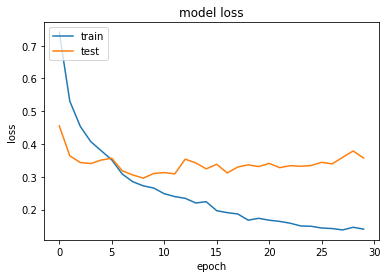

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluating the final model

#### Load model

In [ ]:
final_model_dir = "/content/model.h5"

In [ ]:
final_model = tf.keras.models.load_model(final_model_dir)

#### Evaluation

In [ ]:
final_model.evaluate(val_ds)

134/134 [==============================] - 36s 241ms/step - loss: 0.3312 - accuracy: 0.9081 - precision: 0.9137 - recall: 0.8987 - auc: 0.9924 - true_positives: 1916.0000 - true_negatives: 46723.0000 - false_positives: 181.0000 - false_negatives: 216.0000


[0.3312370479106903,
 0.908067524433136,
 0.913686215877533,
 0.8986867070198059,
 0.9924433827400208,
 1916.0,
 46723.0,
 181.0,
 216.0]

The final model has an accuracy of **90.81%** along with precision of **91.37%** and recall of **89.87%**

#### Confusion matrix and classification report

Since tf.data.Dataset does not fetch images from disk in the same order, so we need to load the validation dataset into memory for consistency

In [ ]:
x = []
y = []
for image,label in val_ds:
  x.append(image)
  y.append(label)

In [ ]:
# Last image batch is removed due to its smaller size
x = np.array(x[:-1])
y = np.array(y[:-1])

print(x.shape)
print(y.shape)

(133, 16, 400, 400, 3)
(133, 16, 23)


In [ ]:
x = np.reshape(x,(x.shape[0]*x.shape[1],img_size,img_size,3))
y = np.reshape(y,(y.shape[0]*y.shape[1],y.shape[2]))

In [ ]:
# Making predictions on the validation dataset
y_pred = final_model.predict(x)

In [ ]:
predicted_categories = tf.argmax(y_pred, axis=-1)

In [ ]:
true_categories = tf.argmax(y, axis=-1)

**The classification report**

In [ ]:
print(classification_report(true_categories, predicted_categories))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       1.00      0.08      0.14        13
           2       0.99      0.96      0.98       125
           3       1.00      0.95      0.97       222
           4       0.98      0.99      0.98       206
           5       0.94      0.96      0.95       201
           6       0.96      0.95      0.96       215
           7       0.57      0.66      0.61        77
           8       0.80      0.65      0.72        55
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.70      1.00      0.82        21
          12       0.97      0.96      0.97       194
          13       0.99      1.00      0.99       201
          14       0.91      0.99      0.95        88
          15       0.99      0.99      0.99       149
          16       0.00      0.00      0.00         6
          17       0.68    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**The confusion matrix**

In [ ]:
conf_matrix = confusion_matrix(true_categories, predicted_categories)
print(conf_matrix)

[[  0   0   0   0   0   0   0   3   1   0   0   0   0   0   0   0   0   0
    0   0   0   0   6]
 [  0   1   0   0   0   0   0   6   1   0   0   0   0   0   0   0   0   0
    0   0   0   0   5]
 [  0   0 120   1   0   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   2   0   1   0]
 [  0   0   1 212   0   0   0   0   0   0   0   9   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   0   0 203   1   0   0   0   0   0   0   0   0   0   0   0   1
    0   1   0   0   0]
 [  0   0   0   0   0 192   8   0   0   0   0   0   0   0   0   0   0   1
    0   0   0   0   0]
 [  0   0   0   0   0  11 204   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   0   0   0   0   0  51   7   0   0   0   0   1   0   0   0   0
    0   0   0   0  18]
 [  0   0   0   0   0   0   0  14  36   0   0   0   0   0   0   0   0   0
    0   0   0   0   5]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
    0   0   0   0   0]
 [  0   0   0   0   0   0   0 

Plotting the confusion matrix using Seaborn



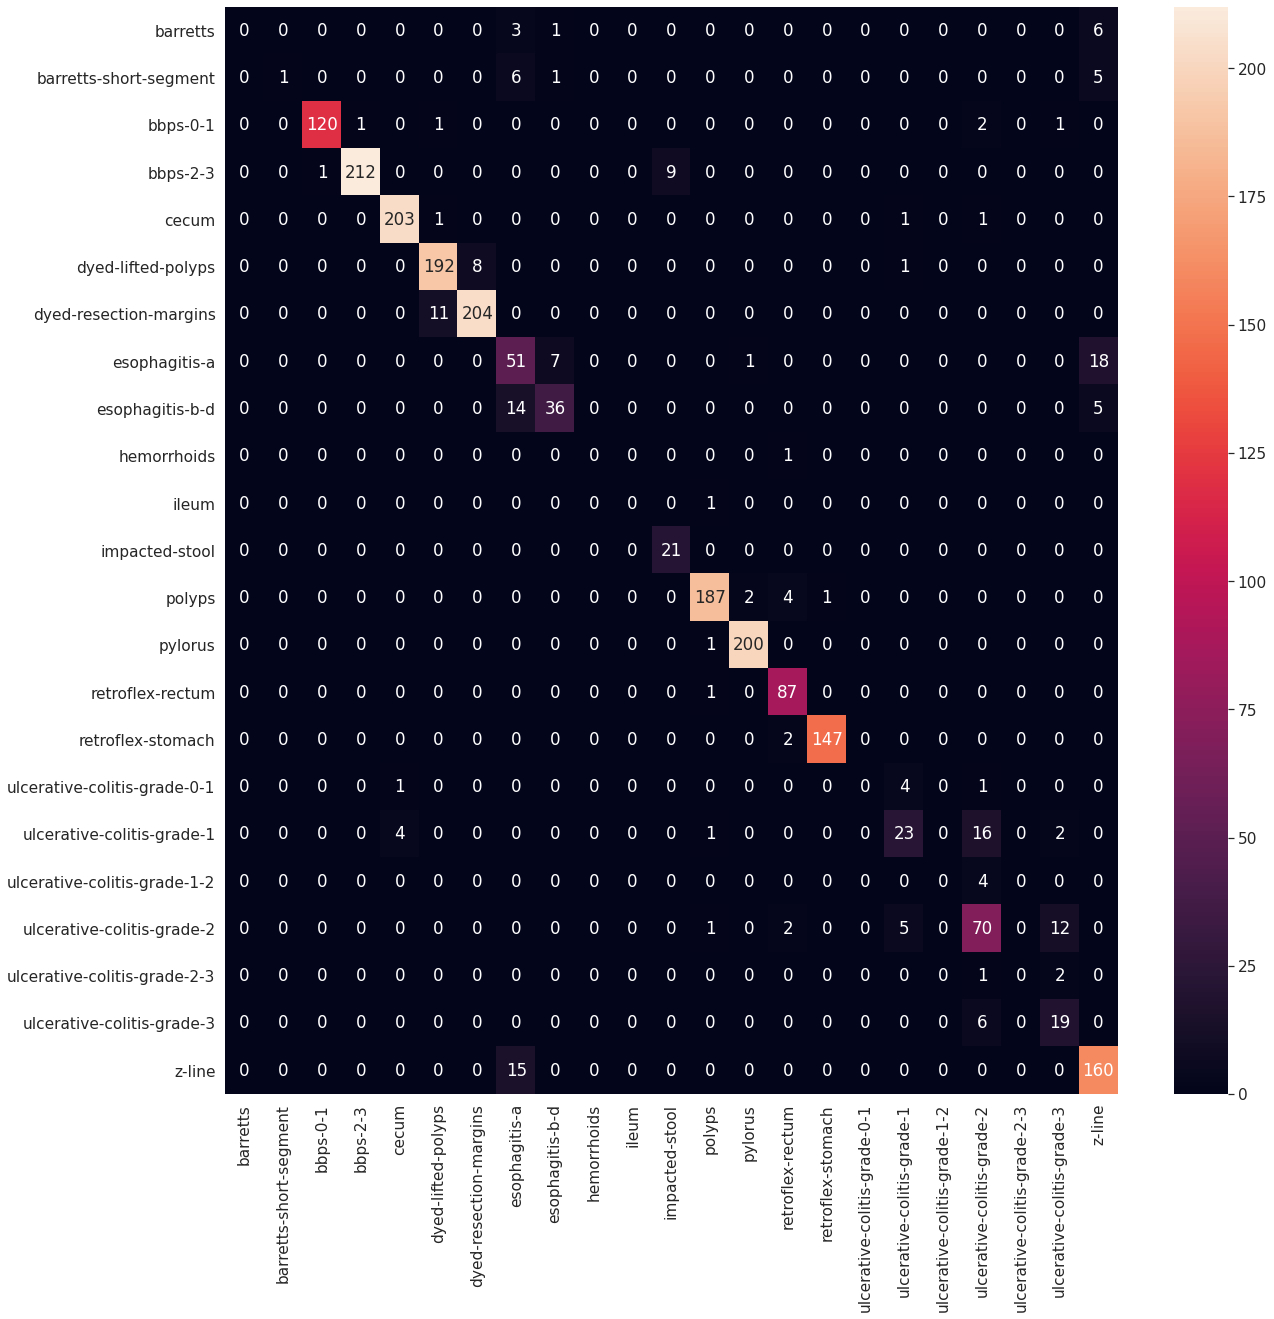

In [ ]:
df_cm = pd.DataFrame(conf_matrix, val_ds.class_names, val_ds.class_names)
plt.figure(figsize=(20,20))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True,fmt='g') # font size

plt.show()

#### Save the model file to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mv "model.h5" "Hyper-Kvasir-DenseNet201-908.h5"

In [ ]:
!mv "Hyper-Kvasir-DenseNet201-908.h5" "/content/gdrive/MyDrive/Models"

In [ ]:
drive.flush_and_unmount()